In [1]:
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

import cv2
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model

from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# **1. Dataset Loading:**

In [2]:
import kagglehub
path=kagglehub.dataset_download("alsaniipe/flowers-multiclass-datasets")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flowers-multiclass-datasets


In [3]:
train_dir = "/kaggle/input/flowers-multiclass-datasets/flowers/flowers/flower_photos/train"
val_dir = "/kaggle/input/flowers-multiclass-datasets/flowers/flowers/flower_photos/validation"
test_dir = "/kaggle/input/flowers-multiclass-datasets/flowers/flowers/flower_photos/test"

# **2. Image Preprocessing:**

In [4]:
batch_size = 32
img_size = (224, 224)

train_ds = keras.utils.image_dataset_from_directory(
    directory = train_dir,
    labels='inferred',
    label_mode="categorical" ,
    batch_size=batch_size,
    image_size=img_size,
)


val_ds = keras.utils.image_dataset_from_directory(
    directory = val_dir,
    labels='inferred',
    label_mode="categorical" ,
    batch_size=batch_size,
    image_size=img_size,
)

test_ds = keras.utils.image_dataset_from_directory(
    directory = test_dir,
    labels='inferred',
    label_mode="categorical" ,
    batch_size=batch_size,
    image_size=img_size,
)

Found 3540 files belonging to 5 classes.
Found 80 files belonging to 5 classes.
Found 50 files belonging to 5 classes.


In [6]:
def visualize_images(path, num_images=5):
    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    if not image_filenames:
        raise ValueError("No images found in the specified path")

    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    for i, image_filename in enumerate(selected_images):
        image_path = os.path.join(path, image_filename)
        image = plt.imread(image_path)

        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)

    plt.tight_layout()
    plt.show()

In [7]:
classes = train_ds.class_names

for label in classes:
    path_to_visualize = f"{train_dir}/{label}"
    print(label.upper())
    visualize_images(path_to_visualize, num_images=5)

Output hidden; open in https://colab.research.google.com to view.

![DAISY](cnn_images/download.png)
![DANDELION](cnn_images/download%20(1).png)
![ROSES](cnn_images/download%20(2).png)
![SUNFLOWERS](cnn_images/download%20(3).png)
![TULIPS](cnn_images/download%20(4).png)

In [5]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# **3. Data Augmentation:**

In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.1)),
    tf.keras.layers.RandomContrast(0.2)
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [10]:
def plot_training_history(history, title="Training History"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title} - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} - Loss')

    plt.tight_layout()
    plt.show()

# **4. Building a VGG CNN from Scratch:**

In [12]:
def vgg_model(input_shape=(224, 224, 3), num_classes=5):
    model = models.Sequential()

    model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

model_vgg = vgg_model()
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg.summary()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_vgg = model_vgg.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stop])

val_loss, val_acc = model_vgg.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.2f}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 302,101 (1.15 MB)

 Trainable params: 302,101 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 73s 540ms/step - accuracy: 0.2641 - loss: 1.5761 - val_accuracy: 0.4625 - val_loss: 1.4583
Epoch 2/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 60s 425ms/step - accuracy: 0.4092 - loss: 1.3706 - val_accuracy: 0.5125 - val_loss: 1.0462
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 83s 439ms/step - accuracy: 0.5040 - loss: 1.1772 - val_accuracy: 0.7000 - val_loss: 0.9490
Epoch 4/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 47s 420ms/step - accuracy: 0.5424 - loss: 1.1078 - val_accuracy: 0.6750 - val_loss: 0.9071
Epoch 5/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 84s 439ms/step - accuracy: 0.5611 - loss: 1.0816 - val_accuracy: 0.6250 - val_loss: 0.9576
Epoch 6/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 46s 414ms/step - accuracy: 0.5975 - loss: 1.0386 - val_accuracy: 0.7750 - val_loss: 0.7710
Epoch 7/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 46s 411ms/step - accuracy: 0.6110 - loss: 0.9961 - val_accuracy: 0.6750 - val_loss: 0.8383
Epoch 8/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 46s 411ms/step - accuracy: 0.6203 - loss: 0

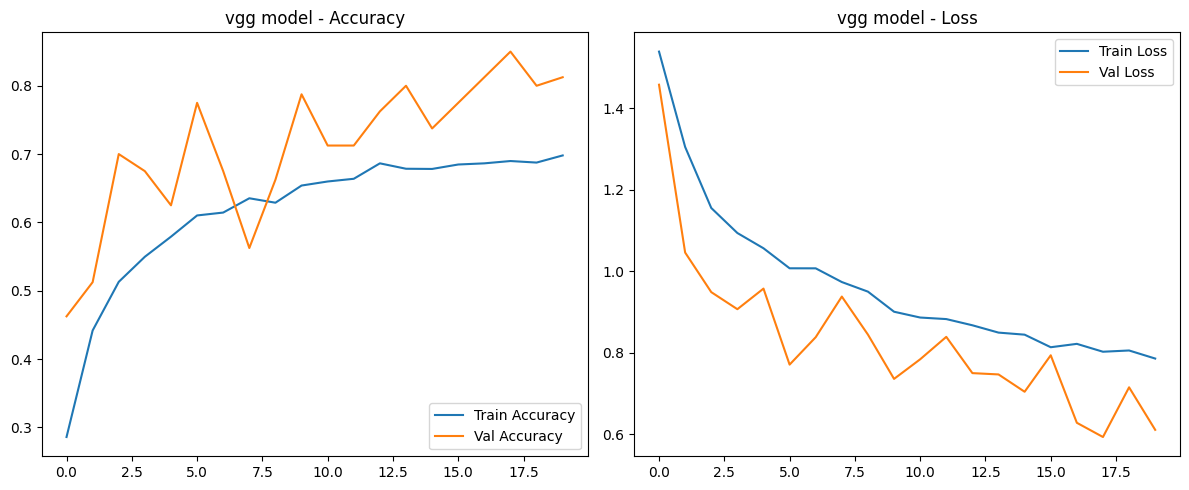

In [13]:
plot_training_history(history_vgg, title="vgg model")

In [8]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(5, activation='softmax')(x)
restnet_1 = tf.keras.Model(inputs, outputs)

restnet_1.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
restnet_1.summary()
history_restnet_1 = restnet_1.fit(train_ds, validation_data=val_ds, epochs=10)

val_loss, val_acc = restnet_1.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.2f}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,629 (90.98 MB)

 Trainable params: 262,917 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 74s 566ms/step - accuracy: 0.2867 - loss: 1.6163 - val_accuracy: 0.3750 - val_loss: 1.5591
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 46s 415ms/step - accuracy: 0.3291 - loss: 1.5317 - val_accuracy: 0.3625 - val_loss: 1.5073
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 46s 415ms/step - accuracy: 0.3580 - loss: 1.4970 - val_accuracy: 0.4125 - val_loss: 1.4606
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 82s 417ms/step - accuracy: 0.3495 - loss: 1.4899 - val_accuracy: 0.4000 - val_loss: 1.4539
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 47s 418ms/step - accuracy: 0.3649 - loss: 1.4789 - val_accuracy: 0.4125 - val_loss: 1.4355
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 47s 416ms/step - accuracy: 0.3785 - loss: 1.4661 - val_accuracy: 0.4125 - val_loss: 1.4140
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 46s 410ms/step - accuracy: 0.3828 - loss: 1.4606 - val_accuracy: 0.4125 - val_loss: 1.3986
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 83s 421ms/step - accuracy: 0.3895 - loss: 1

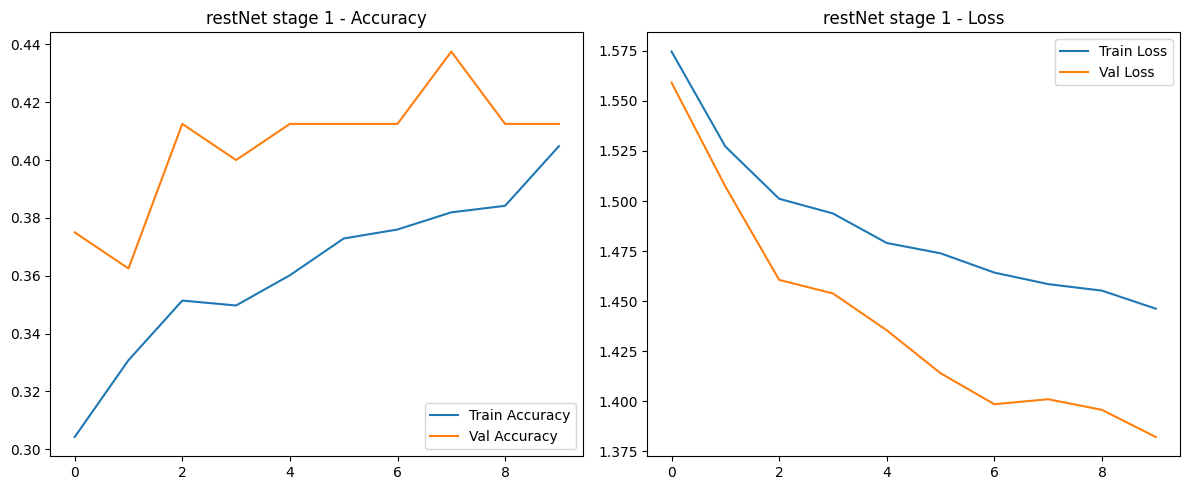

In [11]:
plot_training_history(history_restnet_1, title="restNet stage 1")

In [18]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    if "conv5_block" in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(5, activation='softmax')(x)

restnet_2 = models.Model(inputs=base_model.input, outputs=predictions)
restnet_2.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
restnet_2.summary()
history_restnet_2 = restnet_2.fit(train_ds, validation_data=val_ds, epochs=10)

val_loss, val_acc = restnet_2.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.2f}")

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,629 (90.98 MB)

 Trainable params: 15,238,917 (58.13 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 93s 636ms/step - accuracy: 0.2905 - loss: 1.6035 - val_accuracy: 0.2375 - val_loss: 1.6893
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 47s 421ms/step - accuracy: 0.4519 - loss: 1.3742 - val_accuracy: 0.2625 - val_loss: 1.5068
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 48s 433ms/step - accuracy: 0.4693 - loss: 1.2855 - val_accuracy: 0.5875 - val_loss: 1.2618
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 82s 436ms/step - accuracy: 0.5405 - loss: 1.1869 - val_accuracy: 0.5625 - val_loss: 1.1273
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 48s 428ms/step - accuracy: 0.5498 - loss: 1.1326 - val_accuracy: 0.6000 - val_loss: 1.0578
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 48s 427ms/step - accuracy: 0.5818 - loss: 1.0770 - val_accuracy: 0.6375 - val_loss: 0.9787
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 81s 417ms/step - accuracy: 0.5756 - loss: 1.0477 - val_accuracy: 0.6250 - val_loss: 0.9818
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 83s 424ms/step - accuracy: 0.6046 - loss: 1

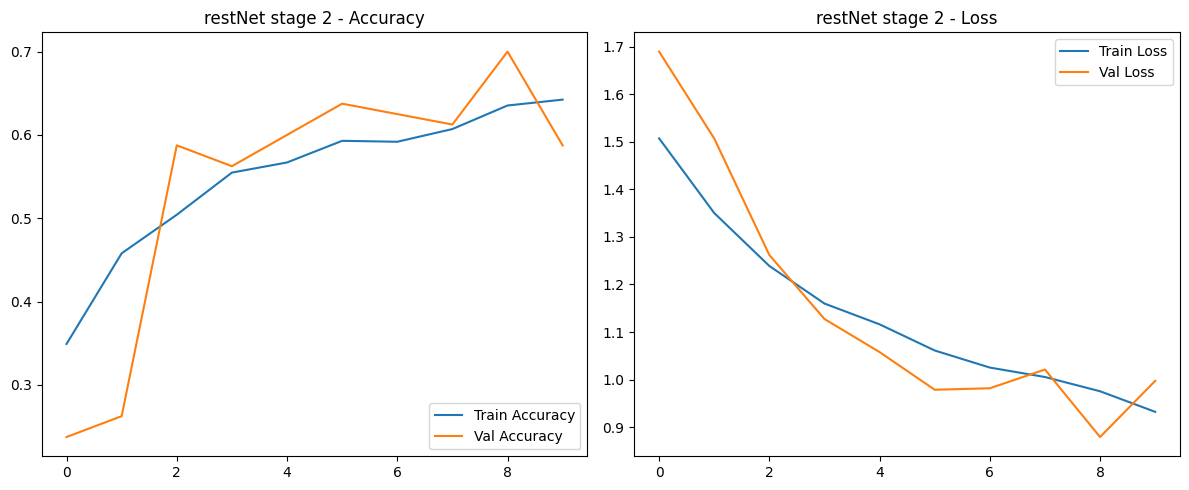

In [19]:
plot_training_history(history_restnet_2, title="restNet stage 2")

In [20]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(5, activation='softmax')(x)

restnet_3 = models.Model(inputs=base_model.input, outputs=predictions)
restnet_3.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
restnet_3.summary()
history_restnet_3 = restnet_3.fit(train_ds, validation_data=val_ds, epochs=10)

val_loss, val_acc = restnet_3.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.2f}")

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_8[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,629 (90.98 MB)

 Trainable params: 23,797,509 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 136s 714ms/step - accuracy: 0.3280 - loss: 1.8134 - val_accuracy: 0.3000 - val_loss: 1.6053
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 92s 471ms/step - accuracy: 0.6765 - loss: 0.8679 - val_accuracy: 0.2125 - val_loss: 1.6775
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 82s 467ms/step - accuracy: 0.7767 - loss: 0.6077 - val_accuracy: 0.2375 - val_loss: 1.6951
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 466ms/step - accuracy: 0.8288 - loss: 0.4811 - val_accuracy: 0.3125 - val_loss: 1.6125
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 53s 469ms/step - accuracy: 0.8564 - loss: 0.3929 - val_accuracy: 0.4250 - val_loss: 1.2499
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 83s 478ms/step - accuracy: 0.8883 - loss: 0.3155 - val_accuracy: 0.6375 - val_loss: 0.8488
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 81s 474ms/step - accuracy: 0.9064 - loss: 0.2730 - val_accuracy: 0.8375 - val_loss: 0.4583
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 53s 473ms/step - accuracy: 0.9146 - loss: 

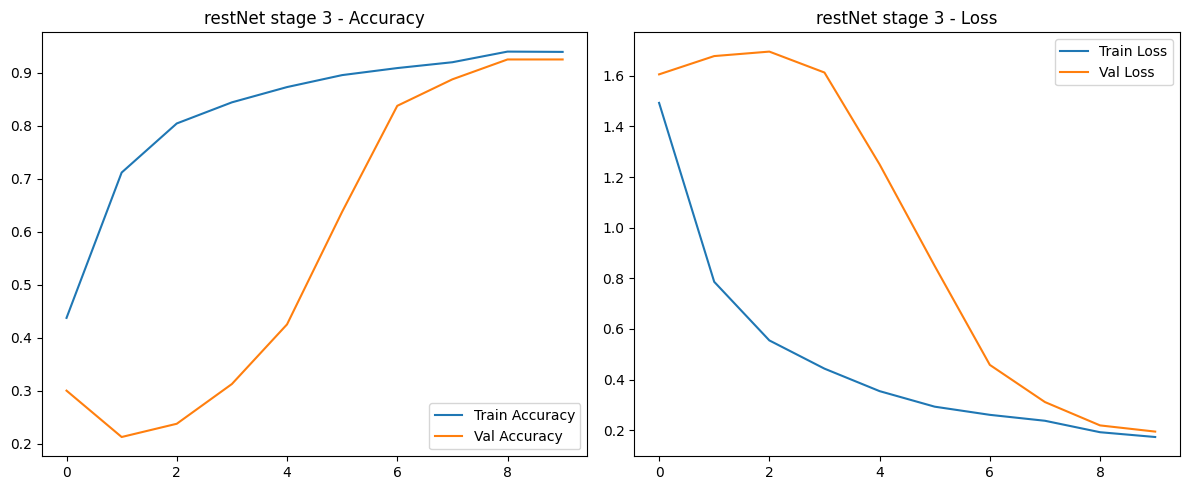

In [21]:
plot_training_history(history_restnet_3, title="restNet stage 3")

In [23]:
def get_predictions_and_labels(model, dataset):
    y_true = []
    y_pred = []
    y_proba = []

    for images, labels in dataset:
        preds = model.predict(images)
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))
        y_proba.extend(preds)

    return np.array(y_true), np.array(y_pred), np.array(y_proba)

def evaluate_model(model, dataset, model_name, class_names):
    y_true, y_pred, y_proba = get_predictions_and_labels(model, dataset)

    print(f"\n=== Evaluation Report for {model_name} ===")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curves - {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

    return roc_auc

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step

=== Evaluation Report for VGG Model ===
              precision    recall  f1-score   support

       daisy       0.87      0.81      0.84        16
   dandelion       0.75      0.94      0.83        16
       roses       1.00      0.62      0.77        16
  sunflowers       0.94      1.00      0.97        16
      tulips       0.78      0.88      0.82        16

    accuracy                           0.85        80
   macro avg       0.87      0.85      0.85        80
weighted avg       0.87      0.85      0.85        80



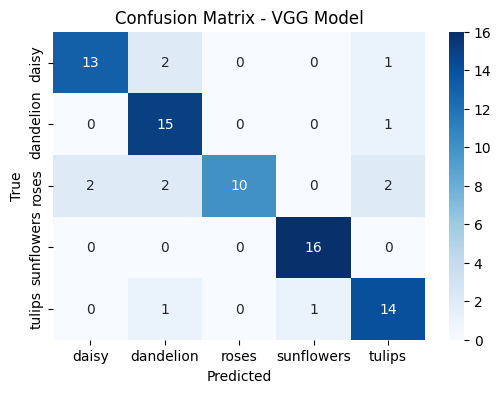

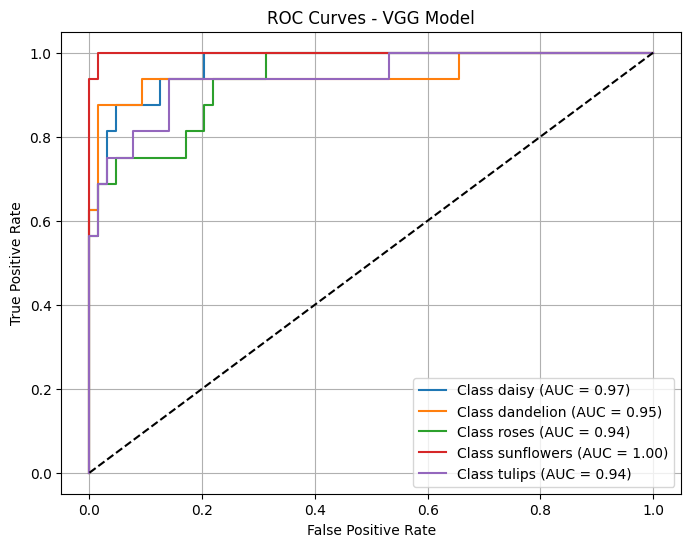

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

=== Evaluation Report for ResNet Stage 1 ===
              precision    recall  f1-score   support

       daisy       0.47      0.44      0.45        16
   dandelion       0.30      0.94      0.45        16
       roses       0.00      0.00      0.00        16
  sunflowers       0.00      0.00      0.00        16
      tulips       0.57      0.50      0.53        16

    accuracy                           0.38        80
   macro avg       0.27      0.38      0.29        80
weighted avg       0.27      0.38      0.29        80



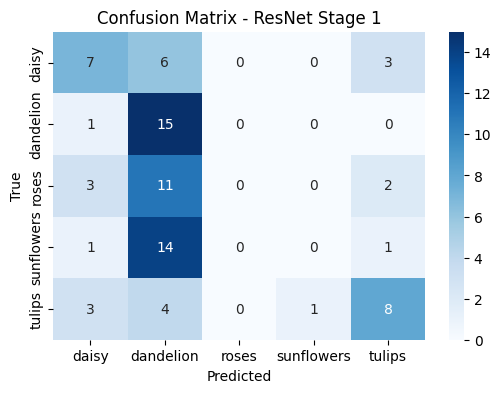

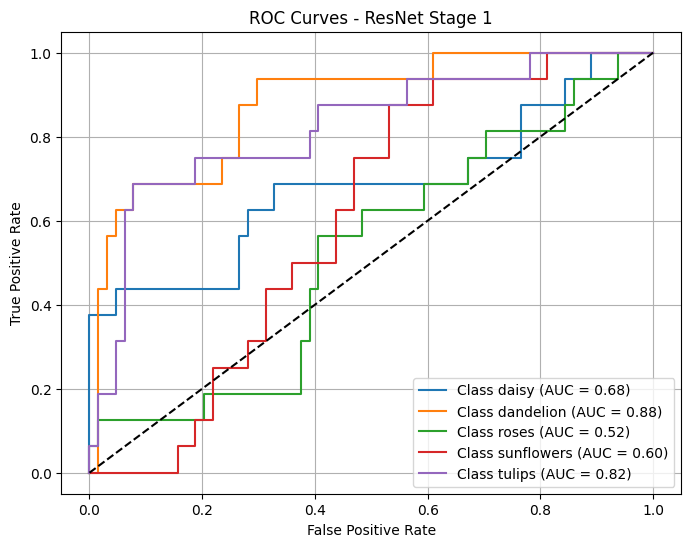

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

=== Evaluation Report for ResNet Stage 2 ===
              precision    recall  f1-score   support

       daisy       0.78      0.44      0.56        16
   dandelion       0.65      0.69      0.67        16
       roses       0.45      0.31      0.37        16
  sunflowers       0.48      0.88      0.62        16
      tulips       0.71      0.62      0.67        16

    accuracy                           0.59        80
   macro avg       0.62      0.59      0.58        80
weighted avg       0.62      0.59      0.58        80



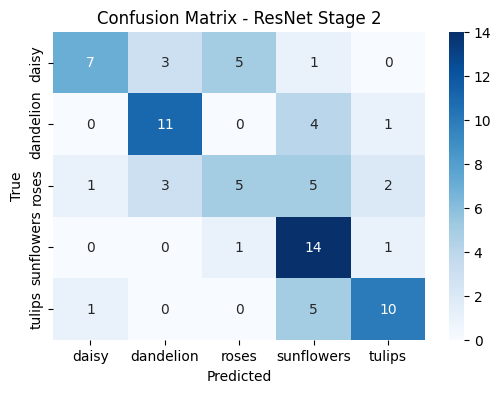

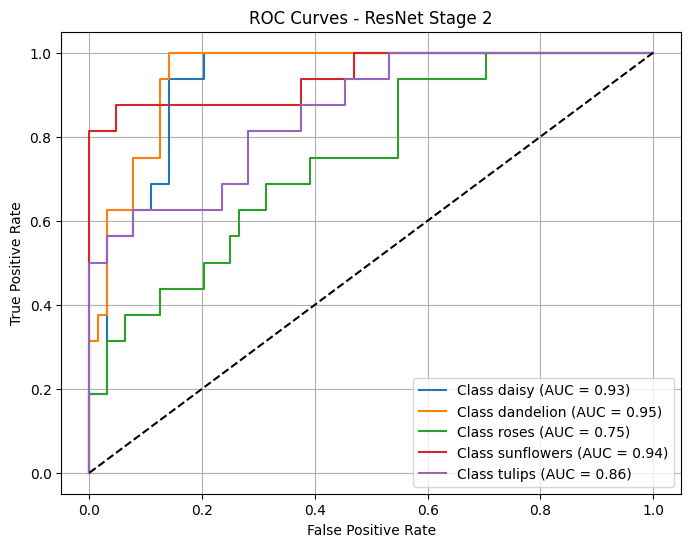

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

=== Evaluation Report for ResNet Stage 3 ===
              precision    recall  f1-score   support

       daisy       1.00      0.94      0.97        16
   dandelion       0.89      1.00      0.94        16
       roses       0.93      0.81      0.87        16
  sunflowers       0.94      1.00      0.97        16
      tulips       0.88      0.88      0.88        16

    accuracy                           0.93        80
   macro avg       0.93      0.93      0.92        80
weighted avg       0.93      0.93      0.92        80



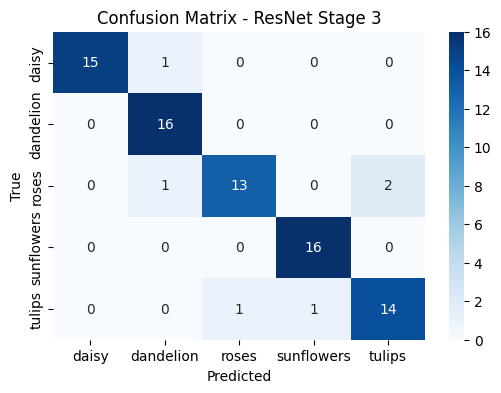

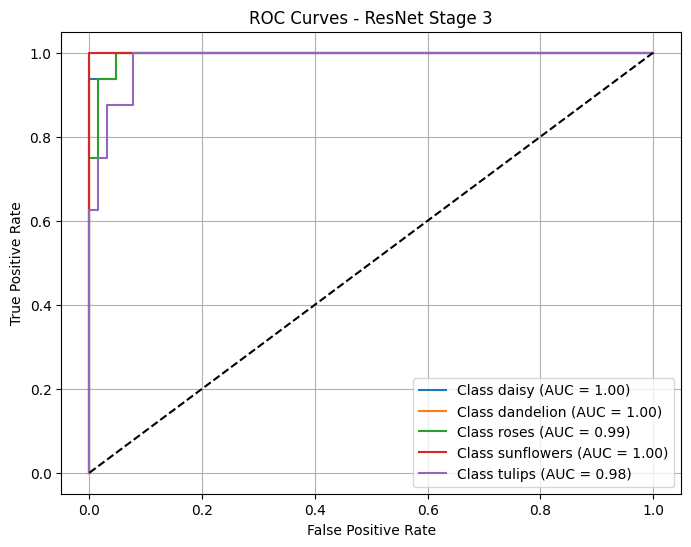

{0: np.float64(0.9970703125),
 1: np.float64(1.0),
 2: np.float64(0.994140625),
 3: np.float64(1.0),
 4: np.float64(0.984375)}

In [24]:
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
evaluate_model(model_vgg, val_ds, "VGG Model", class_names)
evaluate_model(restnet_1, val_ds, "ResNet Stage 1", class_names)
evaluate_model(restnet_2, val_ds, "ResNet Stage 2", class_names)
evaluate_model(restnet_3, val_ds, "ResNet Stage 3", class_names)


## **Question 2**

## **A. Learnable parameters in the convolutional layer**

Each filter has dimensions $2 \times 2 \times 3$, so:

* **Weights per filter** = $2 \times 2 \times 3 = 12$
* Each filter also typically has **1 bias term**

So, for **each filter**:

* Total parameters = $12 \text{ (weights)} + 1 \text{ (bias)} = 13$

There are **3 filters**, so total parameters:

$$
3 \times 13 = {39 \text{ learnable parameters}}
$$



## **B. Fully connected layer replicating the convolutional layer**

### 1. Output size of the convolutional layer:

* Input size: $28 \times 28$
* Filter size: $2 \times 2$
* Stride: 1 (default)
* Padding: valid

So the output spatial size becomes:

$$
(28 - 2 + 1) \times (28 - 2 + 1) = 27 \times 27
$$

With **3 filters**, the output volume is: $27 \times 27 \times 3 = 2187$ values.

### 2. Fully connected layer:

To mimic the same output (2187 values), the FC layer must take **all 28×28×3 = 2352** input pixels and output 2187 values.

So the fully connected layer has:

* **Weights**: $2352 \text{ inputs} \times 2187 \text{ outputs} = 5,141,424$
* **Biases**: 1 per output → 2187

$$
\text{Total parameters} = 5,141,424 + 2187 = {5,143,611 \text{ parameters}}
$$
